In [1]:
import re
import unicodedata
import pandas as pd
import nltk
import acquire as aqr
import prepare as prep
from wordcloud import WordCloud

import json
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jongarcia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


___
## 1. Spam Data
___
---

In [2]:
df = aqr.get_spam_data()

In [3]:
df

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5567,5567,spam,This is the 2nd time we have tried 2 contact u...
5568,5568,ham,Will Ì_ b going to esplanade fr home?
5569,5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,5570,ham,The guy did some bitching but I acted like i'd...


Let's first take a look at how many of the messages are spam vs ham:

In [4]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
label,,
ham,4825,0.865937
spam,747,0.134063


Let's apply a basic clean.

In [5]:
# perfomr a basic clean.
df['text'] = df['text'].apply(prep.basic_clean)
df.head(2)

,id,label,text
0,0,ham,go until jurong point crazy available only in ...
1,1,ham,ok lar joking wif u oni


In [6]:
extra_words = ['r', 'u', '2', 'ltgt']

In [7]:
# Apply the function to your text column
df['text'] = df['text'].apply(lambda x: prep.remove_stopwords(x, extra_words))
df

,id,label,text
0,0,ham,go jurong point crazy available bugis n great ...
1,1,ham,ok lar joking wif oni
2,2,spam,free entry wkly comp win fa cup final tkts 21s...
3,3,ham,dun say early hor c already say
4,4,ham,nah think goes usf lives around though
...,...,...,...
5567,5567,spam,2nd time tried contact a750 pound prize claim ...
5568,5568,ham,b going esplanade fr home
5569,5569,ham,pity mood soany suggestions
5570,5570,ham,guy bitching acted like i'd interested buying ...


In [8]:
# Apply the function to your text column
df['text'] = df['text'].apply(prep.lemmatize)

In [9]:
# Join all the text from the DataFrame where the label is 'ham'
ham_words = ' '.join(df[df.label == 'ham'].text)

# Join all the text from the DataFrame where the label is 'spam'
spam_words = ' '.join(df[df.label == 'spam'].text)

# Join all the text from the DataFrame
all_words = ' '.join(df.text)


In [10]:
# After lemmatizing the text, you need to split the words for frequency counting
ham_words = df[df.label == 'ham'].text.str.split(expand=True).stack()
spam_words = df[df.label == 'spam'].text.str.split(expand=True).stack()
all_words = df.text.str.split(expand=True).stack()

In [11]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
Name: count, dtype: int64

In [12]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
',6,6,0
'',15,15,0
''ok'',5,5,0
'an,1,1,0
'anything',1,1,0


In [13]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
get,397,314,83
ur,384,240,144
i'm,380,372,8
go,304,273,31
4,287,168,119
free,275,59,216
ok,272,267,5
know,267,241,26
come,247,242,5


In [14]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])


,all,ham,spam
ask,88,88,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
i'll,169,169,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

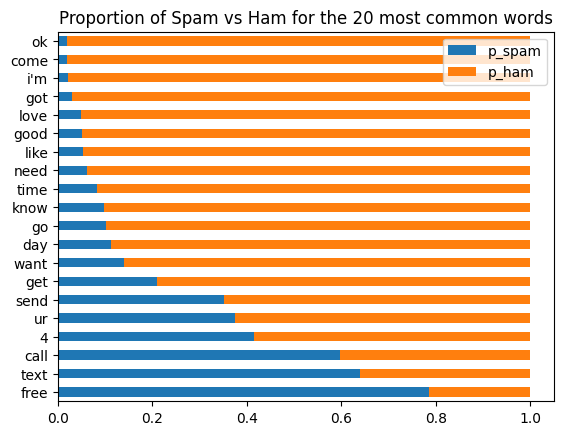

In [15]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')


In [37]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))


,all,ham,spam,ratio
good,235,223,12,0.053809
like,245,232,13,0.056032
need,181,170,11,0.064702
dont,140,129,11,0.085265
time,232,213,19,0.089198
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


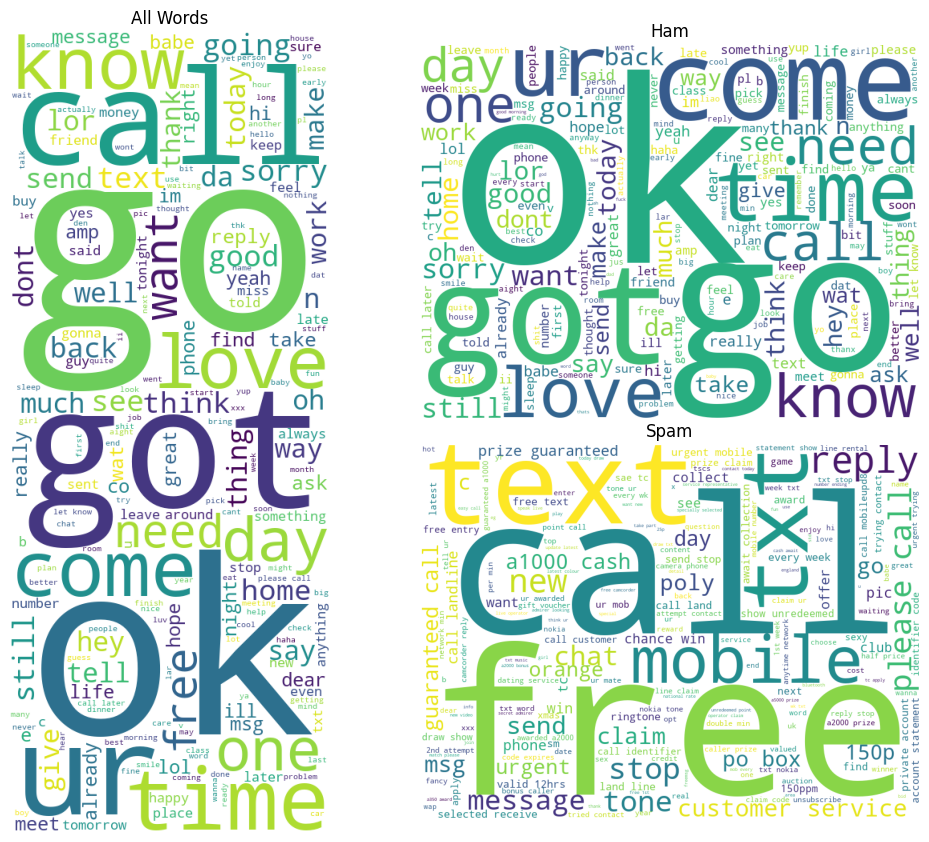

In [17]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


In [18]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()


(call, later)      52
(i'll, call)       44
(let, know)        42
(sorry, i'll)      39
(good, morning)    31
Name: count, dtype: int64

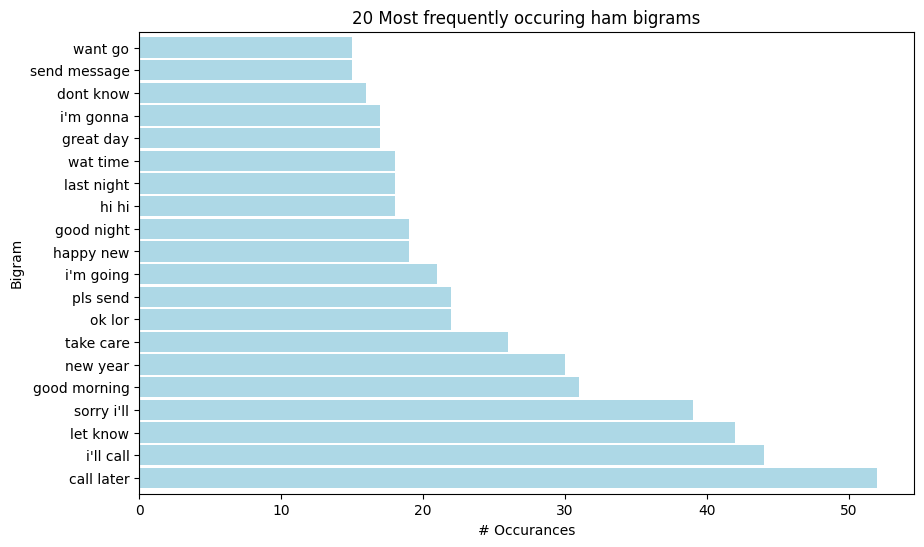

In [19]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [20]:
top_20_ham_bigrams

(call, later)      52
(i'll, call)       44
(let, know)        42
(sorry, i'll)      39
(good, morning)    31
(new, year)        30
(take, care)       26
(ok, lor)          22
(pls, send)        22
(i'm, going)       21
(happy, new)       19
(good, night)      19
(hi, hi)           18
(last, night)      18
(wat, time)        18
(great, day)       17
(i'm, gonna)       17
(dont, know)       16
(send, message)    15
(want, go)         15
Name: count, dtype: int64

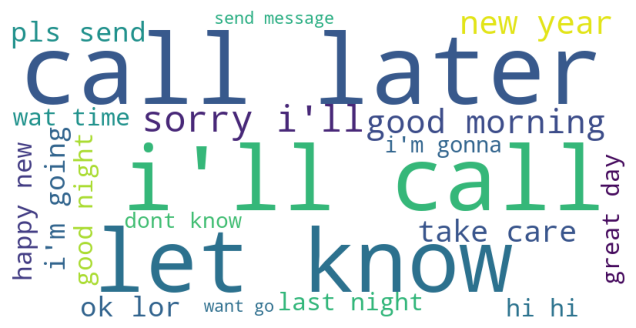

In [21]:
# The first line concats the two words in the bigrams and creates a dictionary with the count. 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


___
## 1. Codeup Blog Data
___
---

In [22]:
# Open and read the JSON file
with open('codeup_blog_articles.json', "r") as json_file:
    blog_articles = json.load(json_file)

# Create a DataFrame from the JSON data
blog_df = pd.DataFrame(blog_articles)

# Check the DataFrame
blog_df.head()

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Codeup is hosting a Women in Tech Panel in hon...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Codeup is hosting a Women in Tech Panel in hon...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Codeup is hosting a Women in Tech Panel in hon...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Codeup is hosting a Women in Tech Panel in hon...


In [23]:
# Perform a basic clean on the 'content' column (or whichever column contains the text of the articles)
blog_df['content'] = blog_df['content'].apply(prep.basic_clean)

# Assuming there might be some common words you'd want to exclude, just like in your spam data,
# you'd include them in `extra_words` and remove them from the content.
extra_words = ['codeup', 'data', 'science']  # add words that are too common in your articles
blog_df['content'] = blog_df['content'].apply(lambda x: prep.remove_stopwords(x, extra_words))

# Lemmatize the content
blog_df['content'] = blog_df['content'].apply(prep.lemmatize)

# Split words for frequency counting after lemmatization
all_words = blog_df['content'].str.split(expand=True).stack()
all_freq = pd.Series(all_words).value_counts()
all_freq.head()

career     486
program    462
student    462
job        424
tech       356
Name: count, dtype: int64

In [25]:
# For the word cloud, you'd use the whole text from 'content'
all_text = ' '.join(blog_df['content'])

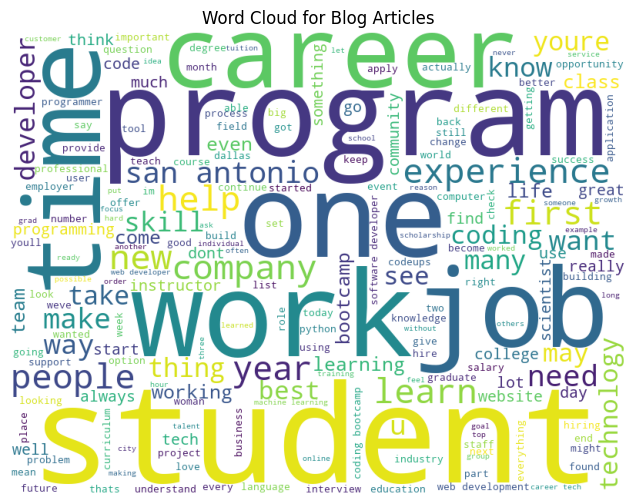

In [26]:
# Generate the word cloud
all_cloud = WordCloud(background_color='white', height=600, width=800).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(all_cloud)
plt.axis('off')
plt.title('Word Cloud for Blog Articles')
plt.show()


In [27]:
# For bigrams, it would be similar to your previous analysis.
all_bigrams_series = pd.Series(nltk.ngrams(all_words, 2)).value_counts()

# Top 20 bigrams
top_20_bigrams = all_bigrams_series.head(20)

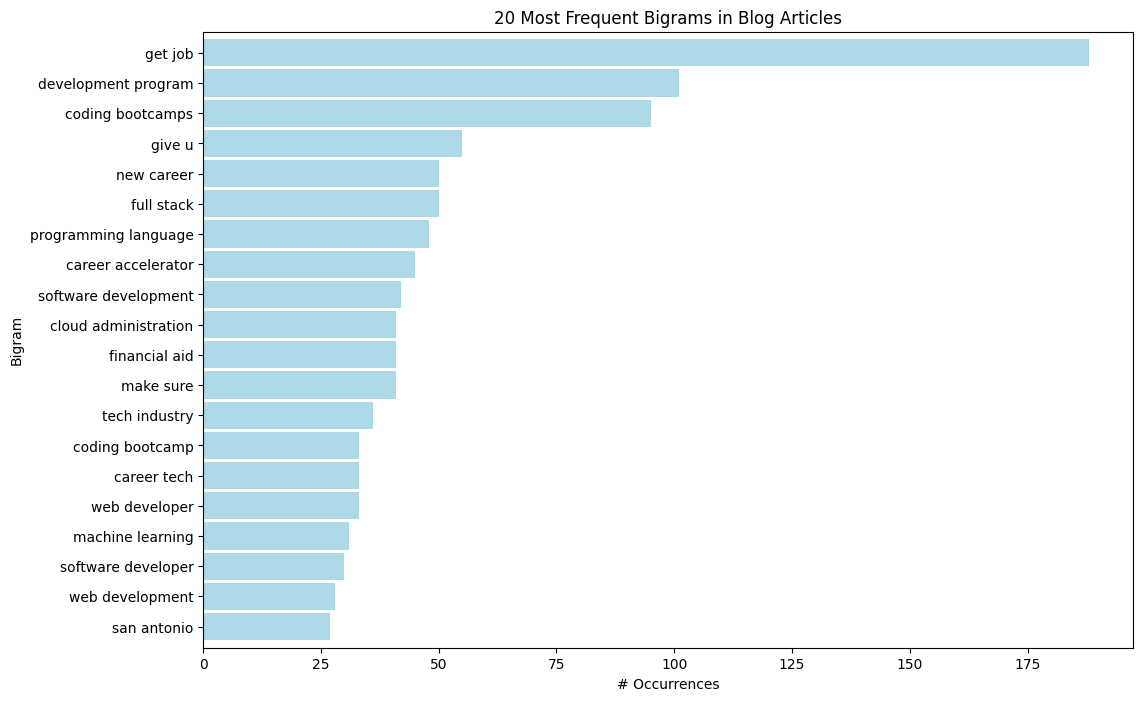

In [32]:
# Plotting the top 20 bigrams
top_20_bigrams.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequent Bigrams in Blog Articles')
plt.ylabel('Bigram')
plt.xlabel('# Occurrences')

# Beautify the labels
ticks, _ = plt.yticks()
labels = top_20_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

plt.show()

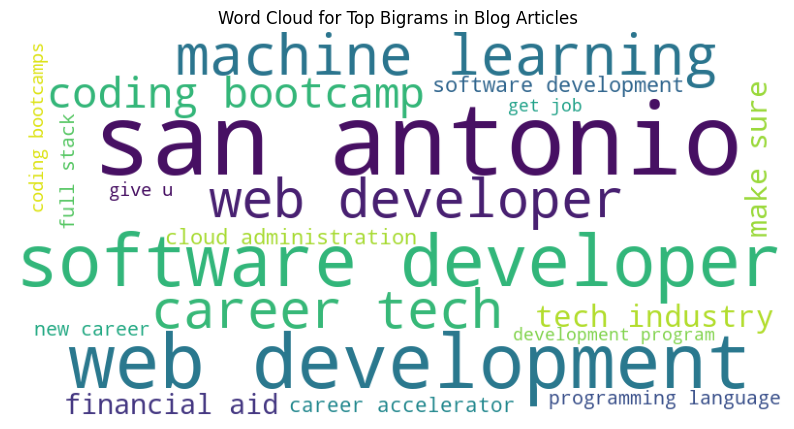

In [30]:
# Similar to the previous analysis, you can create a word cloud for the bigrams
bigram_data = {k[0] + ' ' + k[1]: v for k, v in top_20_bigrams.to_dict().items()}
bigram_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(bigram_data)

plt.figure(figsize=(10, 6))
plt.imshow(bigram_img)
plt.axis('off')
plt.title('Word Cloud for Top Bigrams in Blog Articles')
plt.show()

___
## 3. IN-Shorts News Data
___
---

In [36]:
# Open and read the JSON file
with open('inshorts_articles.json', "r") as json_file:
    inshorts_data = json.load(json_file)

# Create a DataFrame from the JSON data
news_df = pd.DataFrame(inshorts_data)

# Check the DataFrame
news_df.head()

,title,content,category
0,Victoria's Secret ex-CEO cuts Harvard ties for...,Victoria's Secret ex-CEO Leslie Wexner's found...,business
1,HDFC Bank's Vigil Aunty ad gets criticism for ...,HDFC Bank's latest advertisement featuring Vig...,business
2,IMEC big opportunity for investors to partner ...,PM Narendra Modi at the Global Maritime India ...,business
3,"ICICI Bank fined ₹12 crore, Kotak ₹3.95 crore ...",The Reserve Bank of India (RBI) has imposed a ...,business
4,35 lakh weddings in 23 days to generate record...,Traders' body Confederation of All India Trade...,business


In [39]:
# ... [initial setup, imports, and data loading would be here]

# Perform a basic clean on the 'content' column
news_df['content'] = news_df['content'].apply(prep.basic_clean)

# Define any extra words that are common but not informative for the analysis
extra_words = ['said', 'say', 'news']  # Add words that are too common in your articles but not informative
news_df['content'] = news_df['content'].apply(lambda x: prep.remove_stopwords(x, extra_words))

# Lemmatize the content
news_df['content'] = news_df['content'].apply(prep.lemmatize)
news_df.head()

,title,content,category
0,Victoria's Secret ex-CEO cuts Harvard ties for...,victoria's secret exceo leslie wexner's founda...,business
1,HDFC Bank's Vigil Aunty ad gets criticism for ...,hdfc bank's latest advertisement featuring vig...,business
2,IMEC big opportunity for investors to partner ...,pm narendra modi global maritime india summit ...,business
3,"ICICI Bank fined ₹12 crore, Kotak ₹3.95 crore ...",reserve bank india rbi imposed penalty 1219 cr...,business
4,35 lakh weddings in 23 days to generate record...,traders' body confederation india trader cait ...,business


In [40]:
# Split the content by category for frequency counting
business_words = news_df[news_df.category == 'business'].content.str.split(expand=True).stack()
sports_words = news_df[news_df.category == 'sports'].content.str.split(expand=True).stack()
technology_words = news_df[news_df.category == 'technology'].content.str.split(expand=True).stack()
entertainment_words = news_df[news_df.category == 'entertainment'].content.str.split(expand=True).stack()

all_words = news_df.content.str.split(expand=True).stack()

In [42]:
# Calculate word frequencies for each category
business_freq = pd.Series(business_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
technology_freq = pd.Series(technology_words).value_counts()
entertainment_freq = pd.Series(entertainment_words).value_counts()

all_freq = pd.Series(all_words).value_counts()
all_freq.head()

added       14
south       12
employee    11
africa      10
award        9
Name: count, dtype: int64

In [43]:
# Consolidate the word counts in a single DataFrame
word_counts = (pd.concat([all_freq, business_freq, sports_freq, technology_freq, entertainment_freq], axis=1, sort=True)
                .set_axis(['all', 'business', 'sports', 'technology', 'entertainment'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,all,business,sports,technology,entertainment
'dont,1,0,1,0,0
'eras,1,0,0,0,1
'factual',1,0,0,1,0
'financial,1,1,0,0,0
'highway',2,0,0,0,2


In [44]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,business,sports,technology,entertainment
added,14,4,5,2,3
south,12,0,12,0,0
employee,11,5,0,6,0
africa,10,0,10,0,0
cup,9,0,9,0,0
award,9,0,0,0,9
india,9,7,1,1,0
world,9,0,9,0,0
match,8,0,8,0,0
odi,7,0,7,0,0


In [46]:
# Display words unique to each category or common to all
unique_words = pd.concat([
    word_counts[word_counts.business == 0].sort_values(by='sports').tail(6),
    word_counts[word_counts.sports == 0].sort_values(by='business').tail(6),
    word_counts[word_counts.technology == 0].sort_values(by='entertainment').tail(6),
    word_counts[word_counts.entertainment == 0].sort_values(by='technology').tail(6)
])

unique_words

,all,business,sports,technology,entertainment
2023,7,0,7,0,0
match,8,0,8,0,0
world,9,0,9,0,0
cup,9,0,9,0,0
africa,10,0,10,0,0
south,12,0,12,0,0
penalty,3,3,0,0,0
list,6,3,0,3,0
lakh,4,4,0,0,0
employee,11,5,0,6,0


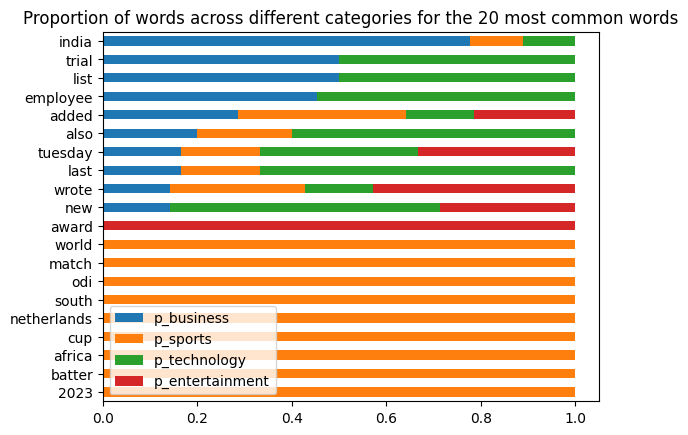

In [47]:
# Calculate the percentage of each category vs all
(word_counts
 .assign(p_business=word_counts.business / word_counts['all'],
         p_sports=word_counts.sports / word_counts['all'],
         p_technology=word_counts.technology / word_counts['all'],
         p_entertainment=word_counts.entertainment / word_counts['all'])
 .sort_values(by='all')
 [['p_business', 'p_sports', 'p_technology', 'p_entertainment']]
 .tail(20)
 .sort_values('p_business')  # Choose one category for sorting
 .plot.barh(stacked=True))

plt.title('Proportion of words across different categories for the 20 most common words')
plt.show()

In [55]:
# Calculate and display the ratio of one category to another for words appearing more than 10 times in each category
significant_words = word_counts[
    (word_counts.business > 0) & 
    (word_counts.sports > 0) &
    (word_counts.technology > 0) &
    (word_counts.entertainment > 0)
]
significant_words

,all,business,sports,technology,entertainment
added,14,4,5,2,3
could,4,1,1,1,1
people,5,1,2,1,1
tuesday,6,1,1,2,2
wrote,7,1,2,1,3


In [59]:
# You might want to calculate the ratios of each category to the sum of the others
significant_words = significant_words.assign(
    ratio_business=lambda news_df: news_df.business / (news_df.sports + news_df.technology + news_df.entertainment + .01),
    ratio_sports=lambda news_df: news_df.sports / (news_df.business + news_df.technology + news_df.entertainment + .01),
    ratio_technology=lambda news_df: news_df.technology / (news_df.business + news_df.sports + news_df.entertainment + .01),
    ratio_entertainment=lambda news_df: news_df.entertainment / (news_df.business + news_df.sports + news_df.technology + .01)
)

# Choose one ratio for sorting, or sort by a custom metric of interest
significant_words = significant_words.sort_values(by='ratio_business')

# Display top and bottom words for the chosen sorting metric
top_bottom_significant = pd.concat([significant_words.head(), significant_words.tail()])
top_bottom_significant


,all,business,sports,technology,entertainment,ratio_business,ratio_sports,ratio_technology,ratio_entertainment
wrote,7,1,2,1,3,0.166389,0.399202,0.166389,0.748130
tuesday,6,1,1,2,2,0.199601,0.199601,0.498753,0.498753
people,5,1,2,1,1,0.249377,0.664452,0.249377,0.249377
could,4,1,1,1,1,0.332226,0.332226,0.332226,0.332226
added,14,4,5,2,3,0.399600,0.554939,0.166528,0.272480
wrote,7,1,2,1,3,0.166389,0.399202,0.166389,0.748130
tuesday,6,1,1,2,2,0.199601,0.199601,0.498753,0.498753
people,5,1,2,1,1,0.249377,0.664452,0.249377,0.249377
could,4,1,1,1,1,0.332226,0.332226,0.332226,0.332226
added,14,4,5,2,3,0.399600,0.554939,0.166528,0.272480


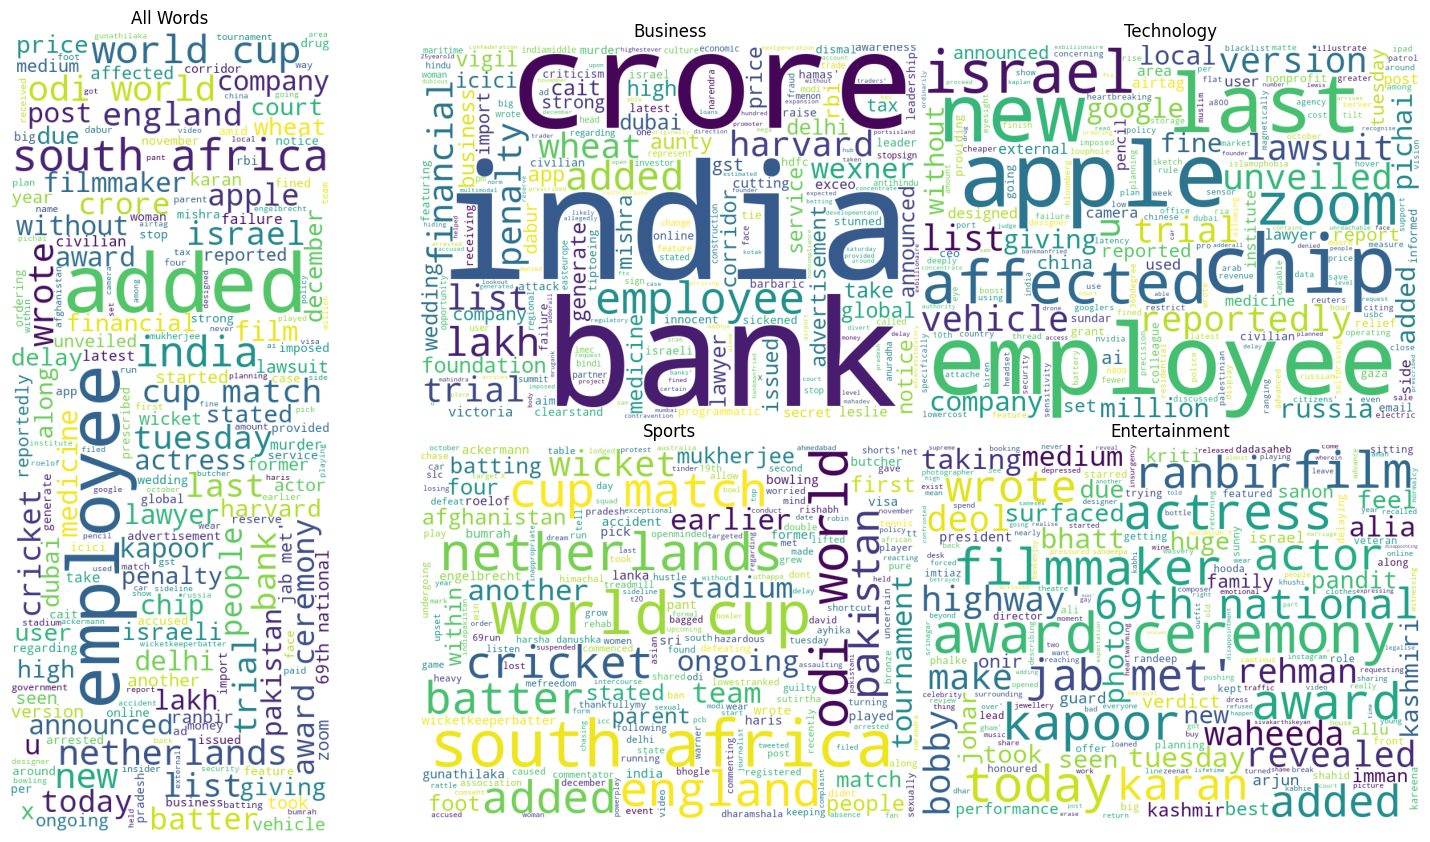

In [58]:
# Generate word clouds for all words and each category
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
business_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(business_words))
sports_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(sports_words))
technology_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(technology_words))
entertainment_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(entertainment_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1, .5, .5, .5]), plt.axes([1, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(business_cloud)
axs[2].imshow(sports_cloud)
axs[3].imshow(technology_cloud)
axs[4].imshow(entertainment_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Business')
axs[2].set_title('Sports')
axs[3].set_title('Technology')
axs[4].set_title('Entertainment')

for ax in axs: ax.axis('off')
plt.show()